In [30]:
%matplotlib widget
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker, cm
from matplotlib.ticker import LogFormatter 

from scipy.optimize import curve_fit
import copy
import os
import h5py
import json

import PyPDF2                       # Per unire i PDF alla fine
import glob                         # Per manipolazione dei path

from collections.abc import Iterable


In [31]:
config_file = r"./config.json"

with open(config_file, "r") as f:
            dizi = json.load(f)
        
dizi
Swan = False

defs

In [32]:
def myGauss(x, a, mu, sigma):
    return a * np.exp(- (x-mu)**2 / (2*sigma**2))

def myGauss_line(x, a, mu, sigma,m,q):
    return a * np.exp(- (x-mu)**2 / (2*sigma**2)) + (m*x + q)

# def project_to_z_pos(z1,z2,z4):
def projectDistZ(x1,x2,y1,y2,z):
    
    mx = (x2-x1)/dizi['d_12']
    xProj = x1 + mx * z
    
    my = (y2-y1)/dizi['d_12']
    yProj = y1 + my * z
    
    return (xProj, yProj)


def Average(lst):
    return sum(lst) / len(lst)

In [33]:
def file_corrector(runs):
    if Swan:
        data_dir = "/eos/project/i/insulab-como/testBeam/TB_T9_2023_08_OREO/HDF5"
    else:
        data_dir = "."

    

    pos = []
    infos = []
    phs = []
    tmis = []
    evis =[]

    if not isinstance(runs, Iterable):
        runs = [runs]

    for run in runs:
        data_path = f'{data_dir}/run{run}.h5'

        with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
            print(hf.keys())
            hf["xpos"].shape
            keys = list(hf.keys())
            #for k in hf.keys():
            #    comand = f'{k} = np.array(hf["{k}"])'
                # print(comand)
            #  exec(comand)
            pos.append(np.array(hf['xpos']))
            infos.append(np.array(hf['xinfo']))
            phs.append(np.array(hf['digiPH']))
            tmis.append(np.array(hf['digiTime']))
            evis.append(np.array(hf['ievent']))

    #print(np.shape(pos))
    # print(np.shape(infos))
            
    xpos = np.concatenate(pos,axis=0)
    xinfo = np.concatenate(infos,axis=0)
    ph = np.concatenate(phs,axis=0)
    tm = np.concatenate(tmis,axis=0)
    evi = np.concatenate(evis,axis=0)

    #print(np.shape(xpos))
    # print(np.shape(xinfo))

    ##purge errors
    logic = (xpos > -1) & (xpos < 15)
    logic2 = logic.all(axis = 1)
    xpos = xpos[logic2]   

    xinfo = xinfo[logic2]
    ph = ph[logic2]
    tm = tm[logic2]
    evi = evi[logic2]
        #NO CORRECTION IN EQUALIZER!
    George = (ph[:,2]+ph[:,3])
    John = (ph[:,4]+ph[:,5])
    Paul = (ph[:,6]+ph[:,7])
    Beatles = np.array([George,John,Paul]).T

    xpos[:,2] -= dizi['offset_x2']
    xpos[:,3] -= dizi['offset_y2']

    x1 = xpos[:,0]
    y1 = xpos[:,1]
    x2 = xpos[:,2] 
    y2 = xpos[:,3] 
    x_cry, y_cry = projectDistZ(x1,x2,y1,y2,dizi['d_1c'])
    return xpos,xinfo,ph,tm,evi,Beatles,x1,y1,x2,y2,x_cry,y_cry 

Equalizer

In [34]:
print(dizi["RunEqualizer"])

nrun = dizi["RunEqualizer"]
xpos,xinfo,ph,tm,evi,Beatles,x1,y1,x2,y2,x_cry,y_cry  = file_corrector(nrun)

rot = xinfo[:,0]
x_cry, y_cry = projectDistZ(x1,x2,y1,y2,dizi['d_1c'])

print()
print(f'{Average(x_cry):.2f},{Average(y_cry):.2f} cm')

680245
<KeysViewHDF5 ['digiBase', 'digiPH', 'digiTime', 'ievent', 'info_plus', 'nclu', 'nstrip', 'xinfo', 'xpos']>

3.73,5.63 cm


(3,)
0 [598.23913903  18.6240489  273.15544896]
La divergenza in x vale 273.16 urad
1 [252.80407173   2.11941885 516.17657459]
La divergenza in y vale 516.18 urad


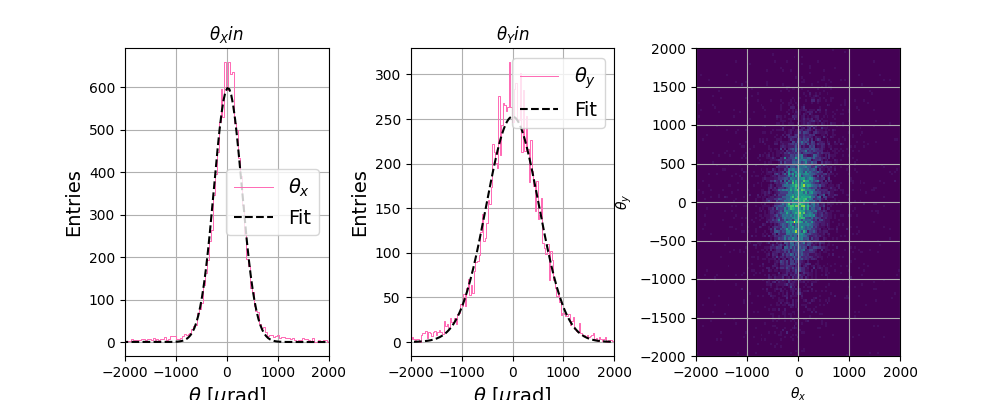

In [35]:
theta_in_x = np.arctan((x_cry-x1)/dizi['d_1c']) * 1e6 # urad
theta_in_y = np.arctan((y_cry-y1)/dizi['d_1c']) * 1e6 # urad

thetain = [theta_in_x, theta_in_y]

thetaLbl = ["x","y","_"]
num_bins = 500

fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,4)
fig.subplots_adjust(wspace=.4,hspace=.8)
ax=ax.flatten()
print(ax.shape)
titles = [fr"$\theta_X in$ ", fr"$\theta_Y in $","_"]
fit_par=[]
for i in range(2):
    h, bins = np.histogram(thetain[i], bins = 500)
    binc = bins[:-1] + (bins[1] - bins[0]) / 2

    p0 = (np.max(h), binc[np.argmax(h)], np.std(thetain[i]))
    cond = h>0
    popt, pcov = curve_fit(myGauss, binc[cond], h[cond], sigma = np.sqrt(h[cond]), absolute_sigma = True, p0 = p0)
    fit_par.append(popt)
    print (i, popt)
    ax[i].plot(binc, h, ds = "steps-mid", c = "hotpink", lw = .7,
               label = fr"$\theta_{thetaLbl[i]}$")
    
    ax[i].plot(binc, myGauss(binc, *popt), ls = "--", c = "k", label = f"Fit")# ({popt[1]:.2f} $\pm$ {popt[2]:.2f} mrad)")
    
    ax[i].grid()
    ax[i].set_title(titles[i])
    ax[i].set_ylabel("Entries", fontsize = 14)    
    ax[i].set_xlabel(r"$\theta$ [$\mu$rad]",fontsize = 14)
    
    ax[i].legend(fontsize = 14)
    
    print(f"La divergenza in {thetaLbl[i]} vale {popt[2]:.2f} urad")


# Creazione del plot
ax[2].hist2d(thetain[0], thetain[1], bins=num_bins)

for a in ax: 
    a.set_xlim((-2000,+2000))

# Etichette degli assi
ax[2].grid()
ax[2].set_xlabel(r"$\theta_x$ ")
ax[2].set_ylabel(r"$\theta_y$ ")
ax[2].set_ylim((-2000,+2000))
plt.show()

time guess (166, 370.986, 15, 0, 0)
[ 1.00220836e+02  3.74230218e+02  3.02422657e+00 -9.80590059e-02
  6.12189111e+01]
Time 374.23 +- 3.02


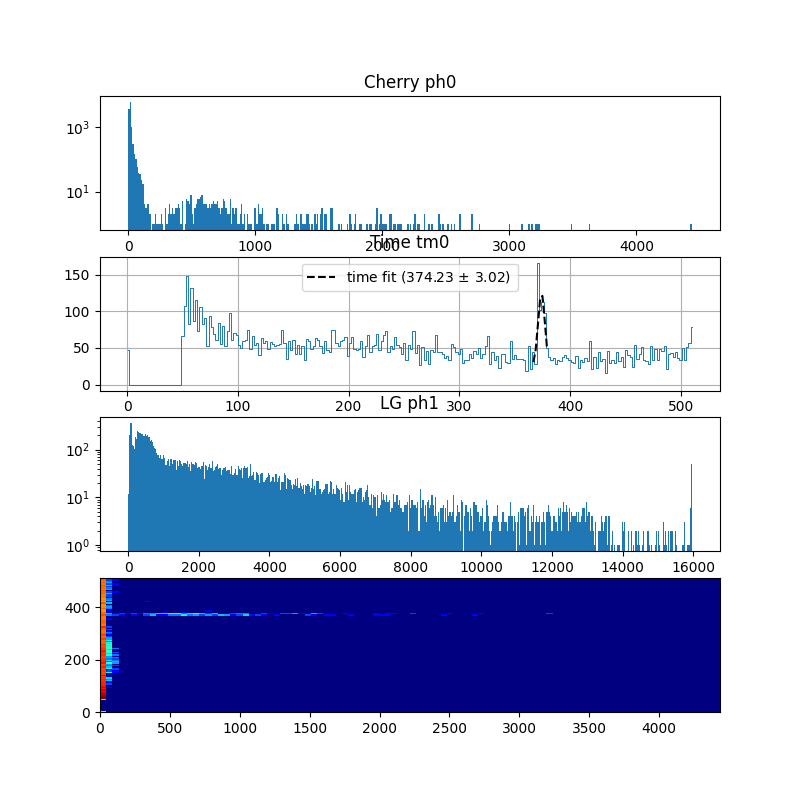

In [36]:
fig, ax = plt.subplots(4,1)
fig.set_size_inches(8,8)
ax[0].hist(ph[:,0],400,log=True)
ax[0].set_title('Cherry ph0')

fit_time = True
if fit_time:
    time_fit_range_min = 365
    time_fit_range_max = 380
    
    # h, bins = np.histogram(tm[:,0][(tm[:,0]< time_fit_range_max) & (tm[:,0]>time_fit_range_min)],int((time_fit_range_max-time_fit_range_min)-3))
    h, bins = np.histogram(tm[:,0],250)
    binc = bins[:-1] + (bins[1] - bins[0]) / 2
    time_fit_range = (binc >= time_fit_range_min) & (binc <= time_fit_range_max)

    x_fit = binc[time_fit_range]
    y_fit = h[time_fit_range]
    #guesses
    p0 = (max(y_fit), x_fit[np.argmax(y_fit)],(time_fit_range_max-time_fit_range_min),0,0)
    print('time guess', p0) 
    time_popt, pcov = curve_fit(myGauss_line, x_fit, y_fit, sigma = np.sqrt(y_fit), absolute_sigma = True, p0 = p0)
    print(time_popt)
    # time_fit_par.append(time_popt)
    ax[1].plot(binc, h, ds = "steps-mid", lw = .7)
    ax[1].plot(x_fit, myGauss_line(x_fit, *time_popt), ls = "--", c = "k",label = f"time fit ({time_popt[1]:.2f} $\pm$ {time_popt[2]:.2f}) ")
    ax[1].grid()
    ax[1].legend(fontsize = 10)
    print(f'Time {time_popt[1]:.2f} +- {time_popt[2]:.2f}')
else:
    # ax[1].hist(tm[:, 0][(tm[:,0]<400) & (tm[:,0]>300)],100,log=True)
    ax[1].hist(tm[:, 0],100,log=True)

ax[1].set_title('Time tm0')


fit_mip = False
if fit_mip:
    mip_fit_range_min = 200
    mip_fit_range_max = 750
    
    # h, bins = np.histogram(ph[:,1][mask_fit_range], 100)
    h, bins = np.histogram(ph[:,1], 500)
    binc = bins[:-1] + (bins[1] - bins[0]) / 2
    mip_fit_range = (binc >= mip_fit_range_min) & (binc <= mip_fit_range_max)
    
    x_fit = binc[mip_fit_range]
    y_fit = h[mip_fit_range]
    # h2, bins2 = np.histogram(ph[:,1], int(len(ph[:,1])/len(ph[:,1][mask_fit_range]))*100)
    # binc2 = bins2[:-1] + (bins2[1] - bins2[0]) / 2
   
    #guesses
    p0 = (max(y_fit), x_fit[np.argmax(y_fit)], len(x_fit))
    print(p0)
    mip_popt, pcov = curve_fit(myGauss, x_fit, y_fit, sigma = np.sqrt(y_fit), absolute_sigma = True, p0 = p0)
    # mip_fit_par.append(mip_popt)
    # ax[2].plot(binc2, h2, ds = "steps-mid", lw = .7)
    ax[2].plot(binc, h, ds = "steps-mid", lw = .7)
    ax[2].axvline(mip_fit_range_max)
    ax[2].axvline(mip_fit_range_min)
    # ax[2].plot(x_fit, myGauss(x_fit, *mip_popt), ls = "--", c = "k",label = f"mip fit ({mip_popt[1]:.2f} $\pm$ {mip_popt[2]:.2f}) ")
    ax[2].grid()
    # ax[2].set_ylabel("Entries", fontsize = 14)    
    ax[2].legend(fontsize = 10)
    print(f'MIP {mip_popt[1]:.2f} +- {mip_popt[2]:.2f}')

fit_el = False
if fit_el:
    el_fit_range_min = 10000
    el_fit_range_max = 15000
    
    # h, bins = np.histogram(ph[:,1][mask_fit_range], 100)
    h, bins = np.histogram(ph[:,1], 100)
    binc = bins[:-1] + (bins[1] - bins[0]) / 2
    el_fit_range = (binc >= el_fit_range_min) & (binc <= el_fit_range_max)
    
    x_fit = binc[el_fit_range]
    y_fit = h[el_fit_range]
    # h2, bins2 = np.histogram(ph[:,1], int(len(ph[:,1])/len(ph[:,1][mask_fit_range]))*100)
    # binc2 = bins2[:-1] + (bins2[1] - bins2[0]) / 2
   
    #guesses
    p0 = (max(y_fit), x_fit[np.argmax(y_fit)], len(x_fit))
    # print(p0)
    el_popt, pcov = curve_fit(myGauss, x_fit, y_fit, sigma = np.sqrt(y_fit), absolute_sigma = True, p0 = p0)
    # el_fit_par.append(el_popt)
    # ax[2].plot(binc2, h2, ds = "steps-mid", lw = .7)
    ax[2].plot(binc, h, ds = "steps-mid", lw = .7)
    ax[2].plot(x_fit, myGauss(x_fit, *el_popt), ls = "--", c = "b",label = f"el fit ({el_popt[1]:.2f} $\pm$ {el_popt[2]:.2f}) ")
    ax[2].grid()
    # ax[2].set_ylabel("Entries", fontsize = 14)    
    ax[2].legend(fontsize = 10)
    print(f'EL {el_popt[1]:.2f} +- {el_popt[2]:.2f}')

if (fit_mip == False) and (fit_el== False):
    # ax[2].hist(ph[:,1][ph[:,0]<200],500,log=True)
    ax[2].hist(ph[:,1],500,log=True)


ax[2].set_title('LG ph1')

my_cmap = copy.copy(mpl.cm.jet) # copy the default cmap
my_cmap.set_bad(my_cmap(0))
ax[3].hist2d(ph[:,0], tm[:,0], bins=[100,100],cmap = my_cmap, norm=mpl.colors.LogNorm())
plt.show()




187.79250000000002 6063
187.79250000000002 9592
187.79250000000002 5900
187.79250000000002 7058
187.79250000000002 6855
187.79250000000002 5466


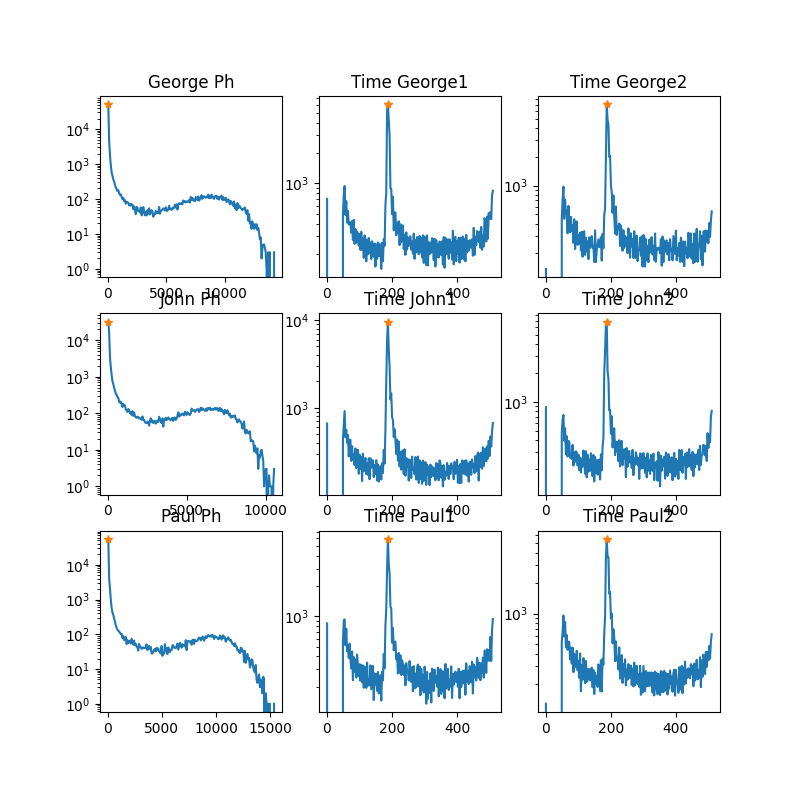

In [46]:
fig, axes = plt.subplots(3,3)
fig.set_size_inches(8,8)
titles = ['George','John','Paul']
time_peak_Beatles =[]
for i in range(3):
    ax = axes[i,0]
    h, bins = np.histogram(ph[:,2+(i*2)]+ph[:,3+(i*2)], bins = 200, )
    binc = bins[:-1] + (bins[1] - bins[0]) / 2
    ax.set_title(titles[i]+' Ph')
    ax.set_yscale('log')
    ax.plot(binc, h)
    ax.plot(binc[np.argmax(h)],np.max(h),'*')
for i in range(3):
    ax = axes[i,1]
    h, bins = np.histogram(tm[:,2+(i*2)], bins = 200, )
    binc = bins[:-1] + (bins[1] - bins[0]) / 2
    ax.set_title('Time '+titles[i]+'1')
    ax.set_yscale('log')
    ax.plot(binc, h)
    ax.plot(binc[np.argmax(h)],np.max(h),'*')
    print(binc[np.argmax(h)],np.max(h))
    time_peak_Beatles.append(binc[np.argmax(h)])
for i in range(3):
    ax = axes[i,2]
    h, bins = np.histogram(tm[:,3+(i*2)], bins = 200, )
    binc = bins[:-1] + (bins[1] - bins[0]) / 2
    ax.set_title('Time '+ titles[i]+'2')
    ax.set_yscale('log')
    ax.plot(binc, h)
    ax.plot(binc[np.argmax(h)],np.max(h),'*')
    print(binc[np.argmax(h)],np.max(h))
    time_peak_Beatles.append(binc[np.argmax(h)])

187.79250000000002
45.792539999999995 MeV
(73676, 3)
(73676,)
[[35.5475, 51345], [26.3975, 32117], [38.54, 55001]]
35.5475 26.3975 38.54
g  0.7425979323440467
j  0.6849377270368449
p  1.0


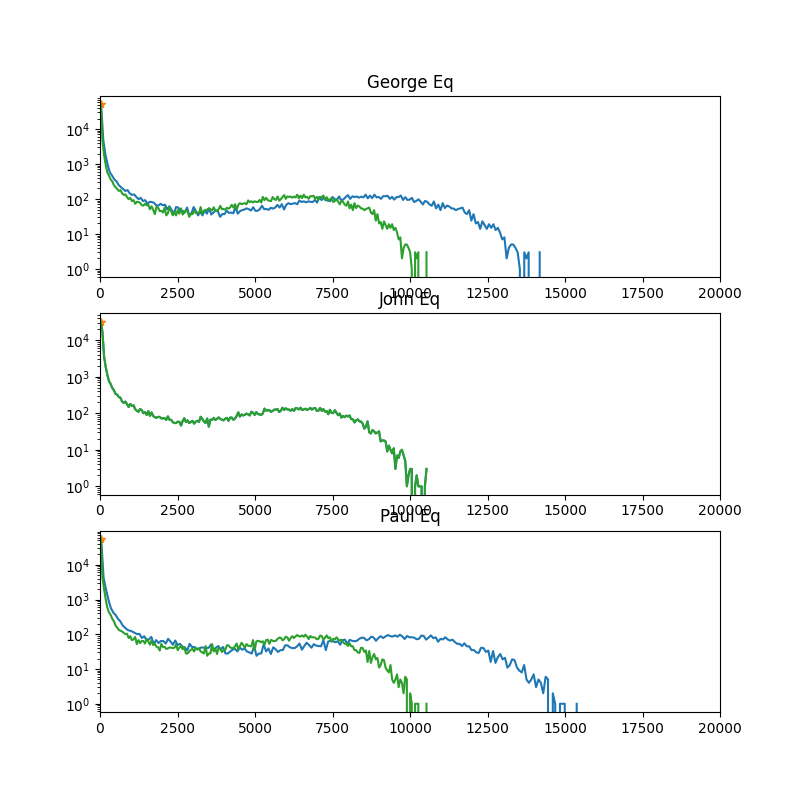

In [50]:
print(Average(time_peak_Beatles))
fig, ax = plt.subplots(3)
fig.set_size_inches(8,8)
titles = ['George','John','Paul']
sipm_time = [Average(time_peak_Beatles) -10 ,Average(time_peak_Beatles) +10]
peak =[]

energy_loss_mip_in_PWO= 1.229*4.5*8.28 #MeV
# energy_loss_mip_in_LG= 1.255 #MeV
print(energy_loss_mip_in_PWO,'MeV')
time_logic_Beatles = [0,0,0]
for i in range(3):
    Si_tm_logic_1 = (tm[:,2+(i*2)] < sipm_time[1] ) & (tm[:,2+(i*2)] > sipm_time[0])
    Si_tm_logic_2 = (tm[:,3+(i*2)] < sipm_time[1]) & (tm[:,3+(i*2)] > sipm_time[0])
    time_logic_Beatles[i] = (Si_tm_logic_1) & (Si_tm_logic_2)

time_logic_Beatles= np.array(time_logic_Beatles).T
print(time_logic_Beatles.shape)
time_logic_si = np.any(time_logic_Beatles,axis=1)
print(time_logic_si.shape)

for i in range(3):
    h, bins = np.histogram(ph[:,2+(i*2)]+ph[:,3+(i*2)], bins = 200, )
    binc = bins[:-1] + (bins[1] - bins[0]) / 2
    ax[i].set_title(titles[i])
    ax[i].set_yscale('log')
    ax[i].plot(binc, h)
    ax[i].plot(binc[np.argmax(h)],np.max(h),'*')
    ax[i].set_xlim(0,20000)
    # ax.hist(ph[:,2+(i*2)][time_logic_si]+ph[:,3+(i*2)][time_logic_si],200)
    peak.append([binc[np.argmax(h)],np.max(h)])



print(peak)
print(peak[0][0],peak[1][0],peak[2][0])


#Equalize the SiPM around Jhon
Equalize = True
if Equalize:
    George = (ph[:,2]+ph[:,3])*(peak[1][0]/peak[0][0])
    Paul = (ph[:,6]+ph[:,7])*(peak[1][0]/peak[2][0])
    John = (ph[:,4]+ph[:,5])
    Beatles = [George,John,Paul]

    print('g ', peak[1][0]/peak[0][0])
    print('j ', peak[1][0]/peak[2][0])
    print('p ', peak[1][0]/peak[1][0])

    with open(config_file, "w") as f:
            json.dump(dizi, f, indent=4)
    
for i in range(3):
    h, bins = np.histogram(Beatles[i], bins = 200, )
    binc = bins[:-1] + (bins[1] - bins[0]) / 2
    ax[i].set_title(titles[i]+" Eq")
    ax[i].set_yscale('log')
    ax[i].set_xlim(0,20000)
    ax[i].plot(binc,h)





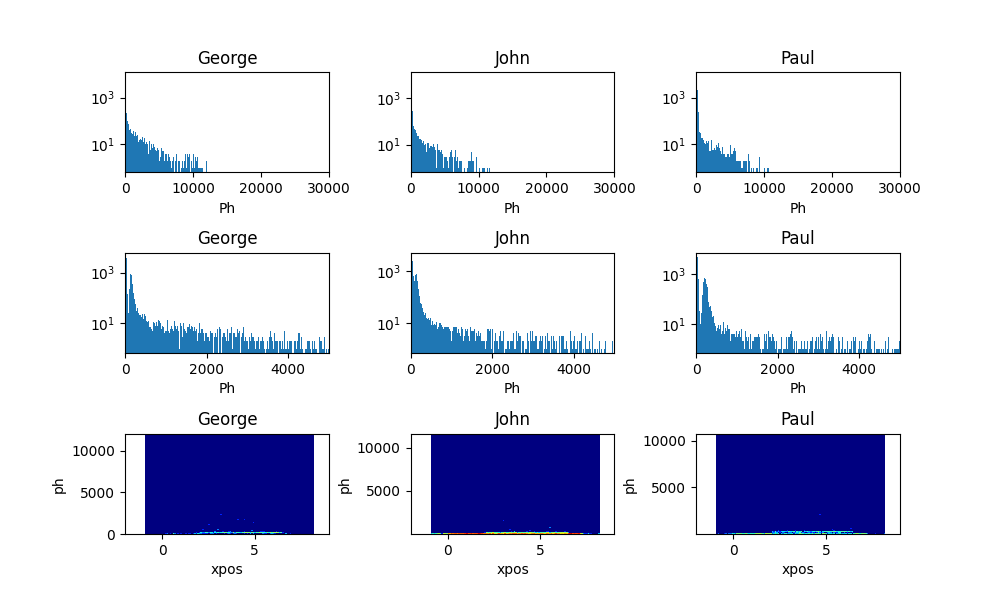

In [39]:
logic_cherry_el = (ph[:, 0]> 200)
if fit_time: cut_tm = [time_popt[1]-time_popt[2], time_popt[1]+time_popt[2]]
if fit_mip: 
    cut_ph_mip = [mip_popt[1]-mip_popt[2], mip_popt[1]+mip_popt[2]]
    logic_mip = (ph[:,1]>[cut_ph_mip[0]]) & (ph[:,1]<[cut_ph_mip[1]])
    x_mip = xpos[logic_mip]
    ph_mip = ph[logic_mip]
    tm_mip= tm[logic_mip]
    xinfo_mip = xinfo[logic_mip]
if fit_el :
    cut_ph_el = [el_popt[1]-el_popt[2], el_popt[1]+el_popt[2]]
    logic_el = (logic_cherry_el) & (ph[:,1]>[cut_ph_el[0]]) & (ph[:,1]<[cut_ph_el[1]])
    #filtri cherenkov MIB vs EL

    x_el = xpos[logic_el]
    ph_el = ph[logic_el]
    tm_el = tm[logic_el]
    xinfo_el = xinfo[logic_el]

#positions of crystal horizzontal
fig, axes = plt.subplots(3,3)
fig.set_size_inches(10,6)
fig.subplots_adjust(wspace=.4,hspace=.8)

titles = ['George','John','Paul']
for i in range(3):
    ax = axes[0,i]
    ax.hist(Beatles[i], bins = 110)
    ax.set_xlabel('Ph')
    ax.set_xlim(0,30000)
    ax.set_yscale('log')
    ax.set_title(titles[i])
    
for i in range(3):
    ax = axes[1,i]
    # ax.hist(ph[:,2+(i*2)]+ph[:,3+(i*2)], bins = 1100)
    ax.hist(Beatles[i], bins = 500)
    ax.set_xlabel('Ph')
    ax.set_xlim(0,5000)
    ax.set_yscale('log')
    # ax.set_ylim(0,30)
    ax.set_title(titles[i])

my_cmap = copy.copy(mpl.cm.jet) # copy the default cmap
my_cmap.set_bad(my_cmap(0))

# print (xpos[:,2].shape)
# print (time_logic_si.shape)
# print (xpos[:,2][time_logic_si].shape)
# print (Beatles[i].shape)

for i in range(3):
    ax = axes[2,i]
    # ax.hist2d(xpos[:,2][time_logic_si][Beatles[i]<2000],Beatles[i][Beatles[i]<2000], bins=[110,500],cmap = my_cmap,norm=mpl.colors.LogNorm())
    ax.hist2d(xpos[:,2],Beatles[i], bins=[110,500],cmap = my_cmap,norm=mpl.colors.LogNorm())
    ax.set_title(titles[i])
    ax.set_xlim(-2,9)
    # ax.set_ylim(0,2000)
    ax.set_xlabel('xpos')
    ax.set_ylabel('ph')

In [40]:
Ph_Th = [80,100,80]
print(time_logic_Beatles.T[:,0].shape)
print(len(Beatles[0])) 

print(time_logic_Beatles[:,0].sum())

(3,)
11519
2707


/var/folders/ds/clcsgq710m905vq5y0gwr98w0000gn/T/ipykernel_11278/2391773500.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,2)
/var/folders/ds/clcsgq710m905vq5y0gwr98w0000gn/T/ipykernel_11278/2391773500.py:17: RuntimeWarning: invalid value encountered in divide
  divisione = h_cut[0] / h_nocut[0]


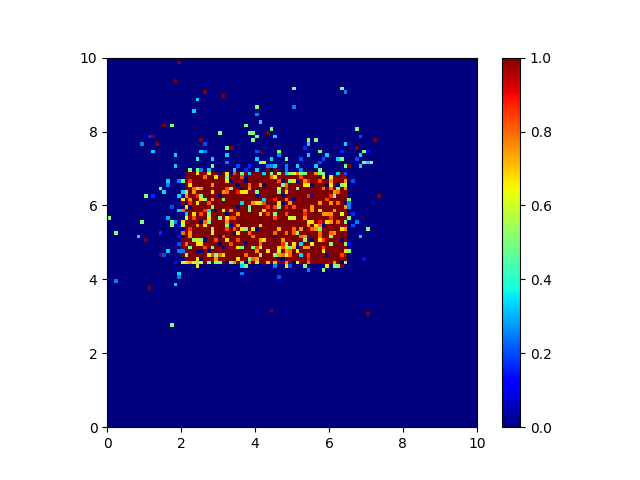

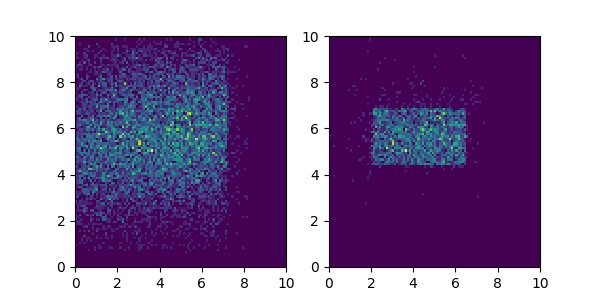

In [41]:
logi = ((time_logic_Beatles[:,0]) & (Beatles[0]>Ph_Th[0])) | ((time_logic_Beatles[:,1]) & (Beatles[1]>Ph_Th[1])) | ((time_logic_Beatles[:,2]) & (Beatles[2]>Ph_Th[2]))


fig, ax = plt.subplots(1,2)
fig.set_size_inches(6,3)
opts = {"bins":100, "range":((0,10), (0,10))}
#plt.hist(ph_el[:,3],200,log=True)
my_cmap = copy.copy(mpl.cm.jet) # copy the default cmap
my_cmap.set_bad(my_cmap(0))

# h_nocut = ax[0].hist2d(x_cry, y_cry, **opts)
h_nocut = ax[0].hist2d(xpos[:,2],xpos[:,3], **opts)
h_cut = ax[1].hist2d(xpos[:,2][logi], xpos[:,3][logi], **opts)



divisione = h_cut[0] / h_nocut[0]

fig, ax = plt.subplots()
myPlotEff = ax.imshow(divisione.T, cmap = my_cmap, origin = "lower",
                       extent = (h_cut[1].min(), h_cut[1].max(), h_cut[2].min(), h_cut[2].max()) )
fig.colorbar(myPlotEff, ax = ax)



plt.show()

/var/folders/ds/clcsgq710m905vq5y0gwr98w0000gn/T/ipykernel_11278/333192931.py:18: RuntimeWarning: invalid value encountered in divide
  divisione = h_cut[0] / h_nocut[0]


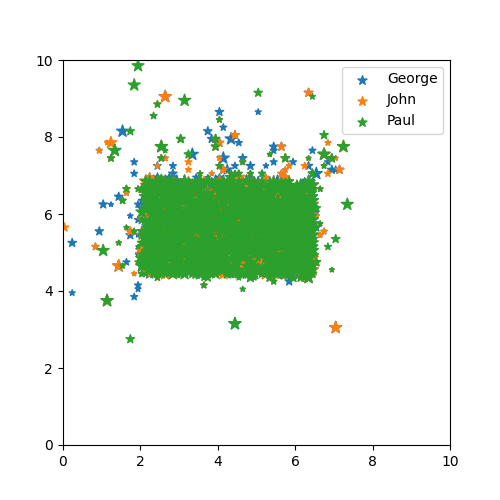

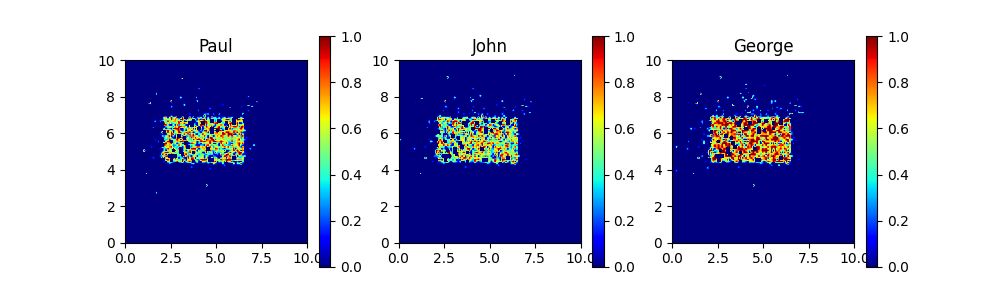

In [42]:

# logi = ((time_logic_Beatles[:,0]) & (Beatles[0]>Ph_Th[0])) 
# logi = ((time_logic_Beatles[:,1]) & (Beatles[1]>Ph_Th[1]))
# logi = ((time_logic_Beatles[:,2]) & (Beatles[2]>Ph_Th[2]))

fig, ax = plt.subplots(1,3)
fig.set_size_inches(10,3)
opts = {"bins":100, "range":((0,10), (0,10))}
#plt.hist(ph_el[:,3],200,log=True)
my_cmap = copy.copy(mpl.cm.jet) # copy the default cmap
my_cmap.set_bad(my_cmap(0))

titles = ['George','John','Paul']
overlap=[]
for i in range (3):
    logi = ((time_logic_Beatles[:,i]) & (Beatles[i]>Ph_Th[i]))
    h_nocut = np.histogram2d(xpos[:,2],xpos[:,3], **opts)
    h_cut = np.histogram2d(xpos[:,2][logi], xpos[:,3][logi], **opts)
    divisione = h_cut[0] / h_nocut[0]
    myPlotEff = ax[2-i].imshow(divisione.T, cmap = my_cmap, origin = "lower",
                       extent = (h_cut[1].min(), h_cut[1].max(), h_cut[2].min(), h_cut[2].max()) )
    fig.colorbar(myPlotEff, ax = ax[2-i])
    ax[2-i].set_title(titles[i])
    overlap.append(divisione)

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
#Primo canale
binc0x = h_cut[1][:-1] + (h_cut[1][1] - h_cut[1][0]) / 2
binc0y = h_cut[2][:-1] + (h_cut[2][1] - h_cut[2][0]) / 2

myGrid = np.meshgrid(binc0x, binc0y)

z0 = overlap[0].T.flatten(order = "C")
x0 = myGrid[0].flatten(order = "C")
y0 = myGrid[1].flatten(order = "C")

ax.scatter(x0[z0>0], y0[z0>0], alpha = 1, marker = "*",
            s = 80 * z0[z0>0], label = "George")
#Secondo canale
z1 = overlap[1].T.flatten(order = "C")
ax.scatter(x0[z1>0], y0[z1>0], alpha = 1, marker = "*",
            s = 80 * z1[z1>0], label = "John")
#Terzo canale
z2 = overlap[2].T.flatten(order = "C")
ax.scatter(x0[z2>0], y0[z2>0], alpha = 1, marker = "*",
            s = 80 * z2[z2>0], label = "Paul")
ax.legend()
ax.set_xlim(0,10)
ax.set_ylim(0,10)

plt.show()

Rot scan


<KeysViewHDF5 ['digiBase', 'digiPH', 'digiTime', 'ievent', 'info_plus', 'nclu', 'nstrip', 'xinfo', 'xpos']>
[[2694 7546  122]
 [  21   34   28]
 [  44   64   42]
 ...
 [  61 4846  756]
 [  14   29   30]
 [  31   43   40]]
[array([598.23913903,  18.6240489 , 273.15544896]), array([252.80407173,   2.11941885, 516.17657459])]


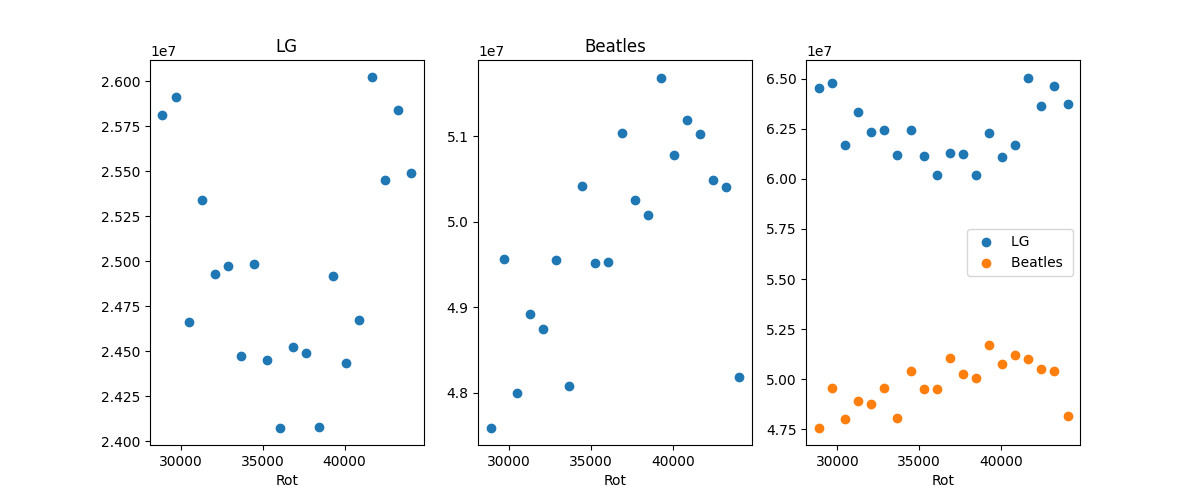

In [43]:
runs = [680233] #Rot Scan
xpos,xinfo,ph,tm,evi,Beatles,x1,y1,x2,y2,x_cry, y_cry  = file_corrector(runs)
print(Beatles)

logic_cherry_el = (ph[:, 0]> 200)
time_logic_Beatles = [0,0,0]
for i in range(3):
    Si_tm_logic_1 = (tm[:,2+(i*2)] < sipm_time[1] ) & (tm[:,2+(i*2)] > sipm_time[0])
    Si_tm_logic_2 = (tm[:,3+(i*2)] < sipm_time[1]) & (tm[:,3+(i*2)] > sipm_time[0])
    time_logic_Beatles[i] = (Si_tm_logic_1) & (Si_tm_logic_2)
time_logic_Beatles= np.array(time_logic_Beatles).T

logic_sipm = ( (Beatles.T[0]>Ph_Th[0]) | (Beatles.T[1]>Ph_Th[1])) | (Beatles.T[2]>Ph_Th[2])
# logic_sipm = ((time_logic_Beatles[:,0]) & (Beatles.T[0]>Ph_Th[0])) |((time_logic_Beatles[:,1]) & (Beatles.T[1]>Ph_Th[1])) | ((time_logic_Beatles[:,2]) & (Beatles.T[2]>Ph_Th[2]))
fig, ax = plt.subplots(1,3)
fig.set_size_inches(12,5)

# print(xinfo[:,0].shape)
# print(logic_sipm.shape)

Rot = np.unique(xinfo[:,0])
# LG_rot =[np.sum(ph[:,1][(xinfo[:,0] == x) & (logic_cherry_el) ]) for x in Rot ]
# Beat_rot =[np.sum(Beatles[(xinfo[:,0] == x) & (logic_cherry_el) ]) for x in Rot ]

LG_rot =np.array([np.sum(ph[:,1][(xinfo[:,0] == x) & (logic_cherry_el) & (logic_sipm)]) for x in Rot ])
Beat_rot =np.array([np.sum(Beatles[(xinfo[:,0] == x) & (logic_cherry_el) & (logic_sipm)]) for x in Rot ])

print(fit_par)

# ax[0].scatter(Rot[:-1] + np.random.normal(fit_par[0][1],fit_par[0][2]), LG_rot[:-1],ls='')
# ax[1].scatter(Rot[:-1] + np.random.normal(fit_par[0][1],fit_par[0][2]), Beat_rot[:-1],ls='')

ax[0].scatter(Rot[:-1], LG_rot[:-1])
ax[1].scatter(Rot[:-1], Beat_rot[:-1])

ax[0].set_title('LG')
ax[1].set_title('Beatles')
ax[0].set_xlabel('Rot')
ax[1].set_xlabel('Rot')

# ax[2].scatter(Rot[:-1]+ np.random.normal(fit_par[0][1],fit_par[0][2]), 2.5*LG_rot[:-1],ls='',label = 'LG (*2.5)')
# ax[2].scatter(Rot[:-1]+ np.random.normal(fit_par[0][1],fit_par[0][2]), 2.5*LG_rot[:-1],ls='',label = 'LG (*2.5)')
ax[2].scatter(Rot[:-1], 2.5*LG_rot[:-1], label = 'LG ')
ax[2].scatter(Rot[:-1], Beat_rot[:-1], label = 'Beatles ')
ax[2].set_xlabel('Rot')
ax[2].legend()

plt.show()

Crad scan

<KeysViewHDF5 ['digiBase', 'digiPH', 'digiTime', 'ievent', 'info_plus', 'nclu', 'nstrip', 'xinfo', 'xpos']>
(73676, 3)
32918
(8,)
(8,)
[array([598.23913903,  18.6240489 , 273.15544896]), array([252.80407173,   2.11941885, 516.17657459])]


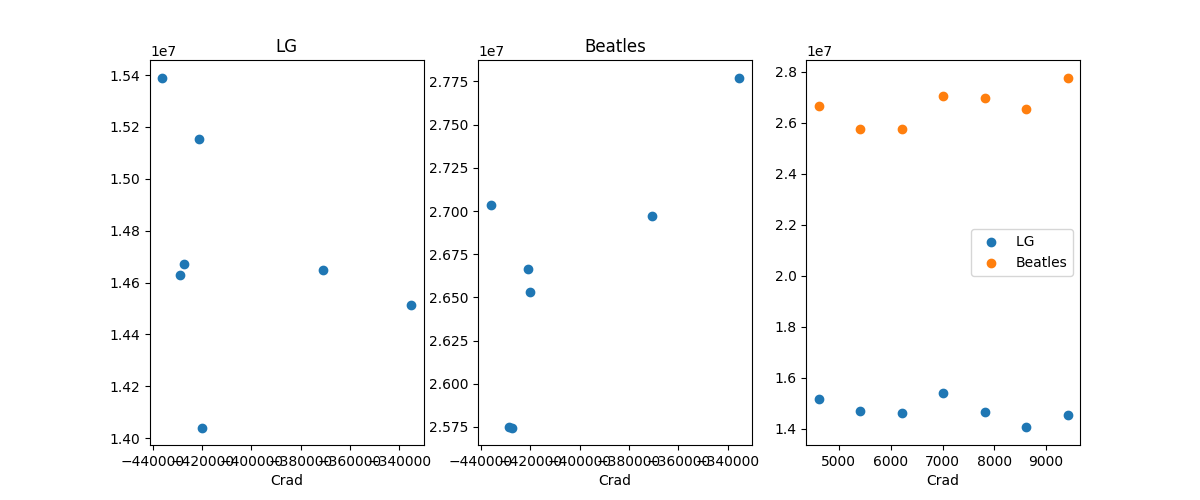

In [44]:
runs = [680251] #Crad Scan
xpos,xinfo,ph,tm,evi,Beatles,x1,y1,x2,y2,x_cry,y_cry  = file_corrector(runs)
print(Beatles.shape)

theta_in_x = np.arctan((x_cry-x1)/dizi['d_1c']) * 1e6 # urad
theta_in_y = np.arctan((y_cry-y1)/dizi['d_1c']) * 1e6 # urad

thetain = [theta_in_x, theta_in_y]

logic_cherry_el = (ph[:, 0]> 150)
time_logic_Beatles = [0,0,0]
for i in range(3):
    Si_tm_logic_1 = (tm[:,2+(i*2)] < sipm_time[1] ) & (tm[:,2+(i*2)] > sipm_time[0])
    Si_tm_logic_2 = (tm[:,3+(i*2)] < sipm_time[1]) & (tm[:,3+(i*2)] > sipm_time[0])
    time_logic_Beatles[i] = (Si_tm_logic_1) & (Si_tm_logic_2)
time_logic_Beatles= np.array(time_logic_Beatles).T

# logic_sipm = ((time_logic_Beatles[:,0]) & (Beatles.T[0]>Ph_Th[0])) |((time_logic_Beatles[:,1]) & (Beatles.T[1]>Ph_Th[1])) | ((time_logic_Beatles[:,2]) & (Beatles.T[2]>Ph_Th[2]))
logic_sipm = ( (Beatles.T[0]>Ph_Th[0]) | (Beatles.T[1]>Ph_Th[1])) | (Beatles.T[2]>Ph_Th[2])
print(logic_sipm.sum())
fig, ax = plt.subplots(1,3)
fig.set_size_inches(12,5)

# print(xinfo[:,1].shape)
# print(logic_sipm.shape)

Crad = np.unique(xinfo[:,1])
# print(Crad.shape)
# LG_rot =[np.sum(ph[:,1][(xinfo[:,0] == x) & (logic_cherry_el) ]) for x in Rot ]
# Beat_rot =[np.sum(Beatles[(xinfo[:,0] == x) & (logic_cherry_el) ]) for x in Rot ]

LG_crad =np.array([np.sum(ph[:,1][(xinfo[:,1] == x) & (logic_cherry_el) & (logic_sipm)]) for x in Crad ])
Beat_crad =np.array([np.sum(Beatles[(xinfo[:,1] == x) & (logic_cherry_el) & (logic_sipm)]) for x in Crad ])
Ty = np.array([np.sum(theta_in_y[(xinfo[:,1] == x) & (logic_cherry_el) & (logic_sipm)]) for x in Crad ])

print(LG_crad.shape)
print(Ty.shape)

ax[0].scatter(Crad[:-1] + Ty[:-1], LG_crad[:-1])
ax[1].scatter(Crad[:-1] + Ty[:-1] , Beat_crad[:-1])

print(fit_par)
# ax[0].scatter(Crad[:-1]+ np.random.normal(fit_par[1][1],fit_par[1][2]), LG_crad[:-1],ls='')
# ax[1].scatter(Crad[:-1]+ np.random.normal(fit_par[1][1],fit_par[1][2]), Beat_crad[:-1],ls='')

ax[0].set_title('LG')
ax[1].set_title('Beatles')

ax[0].set_xlabel('Crad')
ax[1].set_xlabel('Crad')


# ax[2].scatter(Crad[:-1]+ Ty[:-1], 1*LG_crad[:-1],label = 'LG ')
# ax[2].scatter(Crad[:-1]+ Ty[:-1], Beat_crad[:-1], label = 'Beatles')

ax[2].scatter(Crad[:-1], 1*LG_crad[:-1],label = 'LG ')
ax[2].scatter(Crad[:-1], Beat_crad[:-1], label = 'Beatles')
ax[2].set_xlabel('Crad')
ax[2].legend()


plt.show()